In [2]:
from tensorflow.keras.models import load_model
import joblib

# Load the trained model
model = load_model("Models/teacher_dnn_model_lightweight_features.keras")


# Load the scaler
scaler = joblib.load("Features/feature_scaler.pkl")

print("Model and scaler loaded successfully!")

Model and scaler loaded successfully!


In [2]:
import numpy as np
import scipy.stats as stats
import scipy.signal as signal
from scipy.integrate import simpson

class EEGFeatureExtractorLight:
    def __init__(self, sfreq=250):
        self.sfreq = sfreq

    # --------- TIME DOMAIN (light) ---------
    def extract_time_domain(self, x):
        x = np.asarray(x)
        f = {}

        # Basic stats
        f['mean'] = float(np.mean(x))
        f['std'] = float(np.std(x))
        f['median'] = float(np.median(x))
        f['max'] = float(np.max(x))
        f['min'] = float(np.min(x))
        f['range'] = f['max'] - f['min']
        f['iqr'] = float(stats.iqr(x))
        f['kurtosis'] = float(stats.kurtosis(x))
        f['skew'] = float(stats.skew(x))
        f['Q1'] = float(np.percentile(x, 25))
        f['Q3'] = float(np.percentile(x, 75))

        # Temporal activity measures
        diff1 = np.diff(x)
        f['rms'] = float(np.sqrt(np.mean(x**2)))
        f['line_length'] = float(np.sum(np.abs(diff1)))

        centered = x - f['mean']
        f['zero_crossings'] = float(
            np.sum(np.diff(np.signbit(centered).astype(int)) != 0)
        )

        return f

    # --------- FREQUENCY DOMAIN (light) ---------
    def extract_frequency_domain(self, x):
        x = np.asarray(x)
        f = {}

        freqs, psd = signal.welch(x, self.sfreq, nperseg=min(len(x), 256))
        psd_sum = np.sum(psd) + 1e-12
        psd_norm = psd / psd_sum

        # Basic spectral features
        f['peak_freq'] = float(freqs[np.argmax(psd)])
        f['weighted_mean_freq'] = float(np.sum(freqs * psd_norm))
        f['median_freq'] = float(
            freqs[np.where(np.cumsum(psd_norm) >= 0.5)[0][0]]
        )

        # Band powers (delta, theta, alpha, beta)
        bands = {
            'delta': (1, 4),
            'theta': (4, 8),
            'alpha': (8, 13),
            'beta':  (13, 30),
        }

        total_power = 0.0
        for band, (lo, hi) in bands.items():
            idx = (freqs >= lo) & (freqs <= hi)
            power = simpson(y=psd[idx], x=freqs[idx]) if np.any(idx) else 0.0
            f[f'power_{band}'] = float(power)
            total_power += power

        total_power = total_power + 1e-12

        # Relative band powers
        for band in bands.keys():
            f[f'rel_power_{band}'] = float(
                f[f'power_{band}'] / total_power
            )

        # A few simple ratios
        f['ratio_theta_alpha'] = f['power_theta'] / (f['power_alpha'] + 1e-12)
        f['ratio_alpha_beta']  = f['power_alpha'] / (f['power_beta'] + 1e-12)
        f['ratio_delta_beta']  = f['power_delta'] / (f['power_beta'] + 1e-12)

        return f

    # --------- TIME-FREQUENCY (disabled for speed) ---------
    def extract_time_frequency_domain(self, x):
        # Return empty dict to keep interface compatible
        return {}

    # --------- DECOMPOSITION (disabled for speed) ---------
    def extract_decomposition_domain(self, x):
        # Return empty dict to keep interface compatible
        return {}

    def list_feature_names(self, x):
        all_features = {}
        for method in [
            self.extract_time_domain,
            self.extract_frequency_domain,
            self.extract_time_frequency_domain,
            self.extract_decomposition_domain,
        ]:
            all_features.update(method(x))

        print("Total feature count:", len(all_features))
        print("Feature names:")
        for name in all_features:
            print(name)

        return list(all_features.keys())
    
print("EEGFeatureExtractorLight class defined.")

import numpy as np
import scipy.signal as signal
import scipy.fftpack as fftpack
import scipy.stats as stats
from scipy.integrate import simpson

class ECGFeatureExtractorLight:
    def __init__(self, sfreq=250):
        self.sfreq = sfreq

    # --- Helper: Pan-Tompkins QRS Detector (Simplified) ---
    def _detect_qrs(self, x):
        # A. Bandpass Filter (5-15Hz)
        sos = signal.butter(3, [5, 15], 'bandpass', fs=self.sfreq, output='sos')
        filtered = signal.sosfilt(sos, x)
        
        # B. Derivative
        diff = np.diff(filtered)
        
        # C. Squaring
        squared = diff ** 2
        
        # D. Moving Window Integration (150ms)
        window_size = int(0.15 * self.sfreq)
        integrated = np.convolve(squared, np.ones(window_size)/window_size, mode='same')
        
        # E. Peak Finding
        thresh = np.mean(integrated) * 2
        peaks, _ = signal.find_peaks(integrated,
                                     height=thresh,
                                     distance=int(0.2 * self.sfreq))
        return peaks

    # --- Helper: Normalized energy in peak band & harmonics ---
    def _normalized_peak_harmonic_energy(self, freqs, psd, n_harmonics=3, band_width=0.5):
        """
        Compute normalized energy around the dominant frequency and its harmonics.
        """
        freqs = np.asarray(freqs)
        psd = np.asarray(psd)

        if len(freqs) == 0:
            return 0.0, 0.0, 0.0

        total_power = simpson(y=psd, x=freqs)
        if total_power <= 0:
            return 0.0, 0.0, 0.0

        peak_idx = np.argmax(psd)
        f0 = freqs[peak_idx]

        energy_fund = 0.0
        energy_harm = 0.0

        for k in range(1, n_harmonics + 1):
            fk = k * f0
            if fk - band_width > freqs[-1]:
                break

            band_mask = (freqs >= fk - band_width) & (freqs <= fk + band_width)
            if not np.any(band_mask):
                continue

            band_energy = simpson(y=psd[band_mask], x=freqs[band_mask])

            if k == 1:
                energy_fund += band_energy
            else:
                energy_harm += band_energy

        eps = 1e-12
        norm_peak = energy_fund / (total_power + eps)
        norm_harm = energy_harm / (total_power + eps)
        norm_total = (energy_fund + energy_harm) / (total_power + eps)

        return float(norm_peak), float(norm_harm), float(norm_total)

    # ---------- TIME DOMAIN (light) ----------
    def extract_time_domain(self, x):
        x = np.asarray(x)
        f = {}

        # Basic Stats
        f['mean'] = float(np.mean(x))
        f['std'] = float(np.std(x))
        f['median'] = float(np.median(x))
        f['range'] = float(np.max(x) - np.min(x))
        f['skewness'] = float(stats.skew(x))
        f['kurtosis'] = float(stats.kurtosis(x))
        f['rms'] = float(np.sqrt(np.mean(x**2)))
        f['max'] = float(np.max(x))
        f['min'] = float(np.min(x))
        f['IQR'] = float(stats.iqr(x))
        f['Q1'] = float(np.percentile(x, 25))
        f['Q3'] = float(np.percentile(x, 75))

        # QRS & HR Features
        r_peaks = self._detect_qrs(x)

        if len(r_peaks) > 1:
            rr_intervals = np.diff(r_peaks) / self.sfreq  # seconds
            f['heart_rate'] = float(60.0 / np.mean(rr_intervals))      # BPM
            f['heart_rate_variability'] = float(np.std(rr_intervals))  # SDNN
            f['rr_range'] = float(np.max(rr_intervals) - np.min(rr_intervals))
            f['qrs_count'] = int(len(r_peaks))
        else:
            f['heart_rate'] = 0.0
            f['heart_rate_variability'] = 0.0
            f['rr_range'] = 0.0
            f['qrs_count'] = int(len(r_peaks))

        # (LPC removed for speed)

        return f

    # ---------- FREQUENCY DOMAIN (light) ----------
    def extract_frequency_domain(self, x):
        x = np.asarray(x)
        f = {}

        freqs, psd = signal.welch(x, self.sfreq, nperseg=min(len(x), 256))

        f['dominant_freq'] = float(freqs[np.argmax(psd)])
        f['total_power'] = float(np.sum(psd))

        # Normalized peak + harmonics energy
        norm_peak, norm_harm, norm_total = self._normalized_peak_harmonic_energy(
            freqs, psd, n_harmonics=3, band_width=0.5
        )
        f['norm_peak_band_energy'] = norm_peak
        f['norm_harmonics_energy'] = norm_harm
        f['norm_peak_plus_harmonics_energy'] = norm_total

        # Simple DCT summary (cheap)
        dct_val = fftpack.dct(x, type=2, norm='ortho')
        f['dct_mean'] = float(np.mean(np.abs(dct_val)))
        f['dct_var'] = float(np.var(dct_val))

        # (MFCC + Hilbert removed for speed)

        return f

    # ---------- TIME-FREQUENCY (disabled) ----------
    def extract_time_frequency_domain(self, x):
        # Empty dict to keep interface compatible
        return {}

    # ---------- DECOMPOSITION (disabled) ----------
    def extract_decomposition_domain(self, x):
        # Empty dict to keep interface compatible
        return {}

    def list_feature_names(self, x):
        all_features = {}
        for method in [
            self.extract_time_domain,
            self.extract_frequency_domain,
            self.extract_time_frequency_domain,
            self.extract_decomposition_domain,
        ]:
            all_features.update(method(x))

        print("Total feature count:", len(all_features))
        print("Feature names:")
        for name in all_features:
            print(name)

        return list(all_features.keys())

print("ECGFeatureExtractorLight class defined.")

import numpy as np
import scipy.stats as stats
import scipy.signal as signal

class EMGFeatureExtractorLight:
    def __init__(self, sfreq=250):
        self.sfreq = sfreq

    # ---------- TIME DOMAIN (kept, slightly cleaned) ----------
    def extract_time_domain(self, x):
        x = np.asarray(x)
        f = {}

        # --- 1. Basic Statistics ---
        f['mean'] = float(np.mean(x))
        f['std'] = float(np.std(x))
        f['median'] = float(np.median(x))
        f['max'] = float(np.max(x))
        f['min'] = float(np.min(x))
        f['range'] = f['max'] - f['min']
        f['iqr'] = float(stats.iqr(x))
        f['kurtosis'] = float(stats.kurtosis(x))
        f['skewness'] = float(stats.skew(x))
        f['Q1'] = float(np.percentile(x, 25))
        f['Q3'] = float(np.percentile(x, 75))

        # --- 2. Conventional EMG Features ---
        diff1 = np.diff(x)

        # Integrated EMG (IEMG)
        f['integrated_EMG'] = float(np.sum(np.abs(x)))

        # Mean Absolute Value (MAV)
        f['mean_absolute_value'] = float(np.mean(np.abs(x)))

        # Simple Square Integral (SSI)
        f['simple_square_integral'] = float(np.sum(x**2))

        # Root Mean Square (RMS)
        f['RMS'] = float(np.sqrt(np.mean(x**2)))

        # Variance
        f['variance'] = float(np.var(x))

        # Waveform Length (WL)
        f['waveform_length'] = float(np.sum(np.abs(diff1)))

        # Difference Absolute Mean Value (DAMV)
        f['difference_absolute_mean_value'] = float(np.mean(np.abs(diff1)))

        # Difference Variance
        f['difference_variance'] = float(np.var(diff1))

        # Difference Absolute Standard Deviation (DASD)
        f['difference_absolute_standard_deviation'] = float(np.std(diff1))

        # Higher-order difference integrals (still cheap)
        diff2 = np.diff(diff1)
        diff3 = np.diff(diff2)
        f['integrated_absolute_second_derivative'] = float(np.sum(np.abs(diff2)))
        f['integrated_absolute_third_derivative'] = float(np.sum(np.abs(diff3)))

        # Second Order Moment
        f['second_order_moment'] = float(np.mean(x**2))

        # Willison Amplitude (WAMP)
        threshold = 0.1 * f['std']
        f['Willison_amplitude'] = int(np.sum(np.abs(diff1) > threshold))

        # Myopulse Percentage Rate (MYOP)
        f['myopulse_percentage_rate'] = float(
            np.sum(np.abs(x) > threshold) / len(x)
        )

        # --- 3. Counts / Changes ---
        centered = x - f['mean']
        f['zero_crossings'] = int(
            np.sum(np.diff(np.signbit(centered).astype(int)) != 0)
        )

        f['slope_sign_changes'] = int(
            np.sum(np.diff(np.sign(diff1)) != 0)
        )

        # --- 4. Hjorth Parameters ---
        f['Hjorth_activity'] = f['variance']

        if f['variance'] > 0:
            var_diff1 = float(np.var(diff1))
            f['Hjorth_mobility'] = float(np.sqrt(var_diff1 / f['variance']))
        else:
            var_diff1 = 0.0
            f['Hjorth_mobility'] = 0.0

        if f['Hjorth_mobility'] > 0 and var_diff1 > 0:
            var_diff2 = float(np.var(diff2))
            mob_diff = np.sqrt(var_diff2 / var_diff1)
            f['Hjorth_complexity'] = float(mob_diff / f['Hjorth_mobility'])
        else:
            f['Hjorth_complexity'] = 0.0

        # --- 5. Safe exponential / log integrals (clipped) ---
        try:
            f['integrated_exponential'] = float(
                np.sum(np.exp(np.clip(x, -5, 5)))
            )
        except Exception:
            f['integrated_exponential'] = 0.0

        f['integrated_absolute_log'] = float(
            np.sum(np.log(np.abs(x) + 1e-6))
        )

        return f

    # ---------- FREQUENCY DOMAIN (very light) ----------
    def extract_frequency_domain(self, x):
        x = np.asarray(x)
        f = {}

        # Simple FFT-based features
        fft_vals = np.fft.rfft(x)
        freqs = np.fft.rfftfreq(len(x), d=1.0 / self.sfreq)
        mag = np.abs(fft_vals)

        if len(mag) > 0:
            mag_sum = np.sum(mag) + 1e-12
            f['FFT_mean_mag'] = float(np.mean(mag))
            f['FFT_total_energy'] = float(np.sum(mag**2))

            # dominant frequency
            f['FFT_dominant_freq'] = float(freqs[np.argmax(mag)])

            # spectral centroid
            f['FFT_spectral_centroid'] = float(np.sum(freqs * mag) / mag_sum)
        else:
            f['FFT_mean_mag'] = 0.0
            f['FFT_total_energy'] = 0.0
            f['FFT_dominant_freq'] = 0.0
            f['FFT_spectral_centroid'] = 0.0

        # (AR models removed for speed)
        return f

    # ---------- DECOMPOSITION (disabled) ----------
    def extract_decomposition_domain(self, x):
        # Skip wavelet features to save time
        return {}

    def list_feature_names(self, x):
        all_features = {}
        for method in [
            self.extract_time_domain,
            self.extract_frequency_domain,
            self.extract_decomposition_domain,
        ]:
            all_features.update(method(x))

        print("Total feature count:", len(all_features))
        print("Feature names:")
        for name in all_features:
            print(name)

        return list(all_features.keys())


print("EMGFeatureExtractorLight class defined.")

import numpy as np
import scipy.stats as stats
import scipy.signal as signal

class MOVTriaxFeatureExtractorLight:
    def __init__(self, sfreq=250, vertical_axis=2):
        """
        Triaxial MOV feature extractor (lightweight).

        Parameters
        ----------
        sfreq : float
            Sampling frequency (Hz).
        vertical_axis : int
            Index of the vertical acceleration axis (0, 1, or 2).
        """
        self.sfreq = sfreq
        self.vertical_axis = vertical_axis

    # --- Helper: ensure (N, 3) shape ---
    def _ensure_triax_shape(self, arr, name="acc"):
        """
        Accepts (N, 3) or (3, N) and returns (N, 3).
        """
        arr = np.asarray(arr)
        if arr.ndim != 2 or 3 not in arr.shape:
            raise ValueError(f"{name} must be 2D with one dimension = 3, got shape {arr.shape}")
        if arr.shape[1] == 3:
            return arr
        else:
            # assume (3, N)
            return arr.T

    # ---------- TIME DOMAIN ----------
    def extract_time_domain(self, acc, gyro=None):
        """
        acc : array-like, shape (N, 3) or (3, N)
        gyro : array-like, shape (N, 3) or (3, N), optional
        """
        f = {}

        acc = self._ensure_triax_shape(acc, name="acc")
        ax, ay, az = acc[:, 0], acc[:, 1], acc[:, 2]

        # --- Axis-wise stats ---
        f['triax_mean_X'] = float(np.mean(ax))
        f['triax_mean_Y'] = float(np.mean(ay))
        f['triax_mean_Z'] = float(np.mean(az))

        f['triax_variance_X'] = float(np.var(ax))
        f['triax_variance_Y'] = float(np.var(ay))
        f['triax_variance_Z'] = float(np.var(az))

        # --- Resultant magnitude ---
        mag = np.sqrt(ax**2 + ay**2 + az**2)

        # Total sum of vector magnitude over the window
        f['triax_total_sum_vector'] = float(np.sum(mag))

        # Mean magnitude (average length of the sum vector)
        f['triax_sum_vector_magnitude'] = float(np.mean(mag))

        # Activity / single magnitude area: sum of |ax|+|ay|+|az|
        f['triax_activity_single_magnitude_area'] = float(
            np.sum(np.abs(ax) + np.abs(ay) + np.abs(az))
        )

        # --- Dynamic component (subtract DC/gravity per axis) ---
        ax_d = ax - np.mean(ax)
        ay_d = ay - np.mean(ay)
        az_d = az - np.mean(az)
        mag_dyn = np.sqrt(ax_d**2 + ay_d**2 + az_d**2)
        f['triax_dynamic_sum_vector'] = float(np.sum(mag_dyn))

        # --- Vertical acceleration ---
        if self.vertical_axis not in (0, 1, 2):
            raise ValueError("vertical_axis must be 0, 1, or 2")
        a_vert = acc[:, self.vertical_axis]
        f['triax_vertical_acceleration'] = float(np.mean(np.abs(a_vert)))

        # --- Angular velocity aggregate (if gyro provided) ---
        if gyro is not None:
            gyro = self._ensure_triax_shape(gyro, name="gyro")
            gx, gy, gz = gyro[:, 0], gyro[:, 1], gyro[:, 2]
            gyro_mag = np.sqrt(gx**2 + gy**2 + gz**2)
            f['triax_angular_velocity_aggregate'] = float(np.mean(gyro_mag))
        else:
            f['triax_angular_velocity_aggregate'] = 0.0

        return f

    # ---------- FREQUENCY DOMAIN ----------
    def extract_frequency_domain(self, acc):
        """
        Basic frequency-domain features from resultant magnitude.
        """
        f = {}

        acc = self._ensure_triax_shape(acc, name="acc")
        ax, ay, az = acc[:, 0], acc[:, 1], acc[:, 2]
        mag = np.sqrt(ax**2 + ay**2 + az**2)

        fft_vals = np.fft.rfft(mag)
        freqs = np.fft.rfftfreq(len(mag), d=1/self.sfreq)
        mag_abs = np.abs(fft_vals)

        if len(mag_abs) > 0:
            f['triax_fft_mean_mag'] = float(np.mean(mag_abs))
            f['triax_fft_energy'] = float(np.sum(mag_abs**2))
            f['triax_dominant_freq'] = float(freqs[np.argmax(mag_abs)])
        else:
            f['triax_fft_mean_mag'] = 0.0
            f['triax_fft_energy'] = 0.0
            f['triax_dominant_freq'] = 0.0

        return f

    # ---------- DECOMPOSITION DOMAIN (disabled for speed) ----------
    def extract_decomposition_domain(self, acc):
        # Skip wavelet features for the fast run
        return {}

    def list_feature_names(self, acc):
        all_features = {}
        # for triax, we need to pass gyro if you care; here we just ignore gyro
        acc = self._ensure_triax_shape(acc, name="acc")
        for method in [
            self.extract_time_domain,
            self.extract_frequency_domain,
            self.extract_decomposition_domain,
        ]:
            # extract_time_domain expects (acc, gyro=None)
            if method is self.extract_time_domain:
                all_features.update(method(acc))
            else:
                all_features.update(method(acc))

        print("Total feature count (triax):", len(all_features))
        print("Feature names:")
        for name in all_features:
            print(name)

        return list(all_features.keys())


class MOV1DFeatureExtractorLight:
    def __init__(self, sfreq=250):
        self.sfreq = sfreq

    def extract_time_domain(self, x):
        x = np.asarray(x)
        f = {}

        # --- 1. Basic Statistics ---
        f['mean'] = float(np.mean(x))
        f['std'] = float(np.std(x))
        f['median'] = float(np.median(x))
        f['max'] = float(np.max(x))
        f['min'] = float(np.min(x))
        f['range'] = f['max'] - f['min']
        f['iqr'] = float(stats.iqr(x))
        f['kurtosis'] = float(stats.kurtosis(x))
        f['skewness'] = float(stats.skew(x))
        f['Q1'] = float(np.percentile(x, 25))
        f['Q3'] = float(np.percentile(x, 75))

        # --- 2. Temporal Features ---
        f['signal_magnitude_area'] = float(np.sum(np.abs(x)))

        centered = x - f['mean']
        f['zero_crossing_rate'] = float(
            np.sum(np.diff(np.signbit(centered).astype(int)) != 0) / len(x)
        )

        peaks, _ = signal.find_peaks(x, prominence=0.5 * f['std'])
        f['peak_count'] = int(len(peaks))

        # --- 3. Trajectory Features ---
        first = x[0]
        last = x[-1]
        mx = f['max']
        mn = f['min']

        f['val_first_minus_last'] = float(first - last)
        f['val_first_minus_max'] = float(first - mx)
        f['val_first_minus_min'] = float(first - mn)
        f['val_last_minus_max'] = float(last - mx)
        f['val_last_minus_min'] = float(last - mn)

        # --- 4. Acceleration Order (Ranking) ---
        sorted_x = np.sort(x)
        f['rank_last_value'] = float(np.searchsorted(sorted_x, last) / len(x))
        f['rank_min_value'] = 0.0

        return f

    def extract_frequency_domain(self, x):
        x = np.asarray(x)
        f = {}

        fft_vals = np.fft.rfft(x)
        freqs = np.fft.rfftfreq(len(x), d=1/self.sfreq)
        mag = np.abs(fft_vals)

        if len(mag) > 0:
            f['fft_mean_mag'] = float(np.mean(mag))
            f['fft_energy'] = float(np.sum(mag**2))
            f['dominant_freq'] = float(freqs[np.argmax(mag)])
        else:
            f['fft_mean_mag'] = 0.0
            f['fft_energy'] = 0.0
            f['dominant_freq'] = 0.0

        return f

    def extract_decomposition_domain(self, x):
        # Skip wavelet features for speed
        return {}

    def list_feature_names(self, x):
        all_features = {}
        for method in [
            self.extract_time_domain,
            self.extract_frequency_domain,
            self.extract_decomposition_domain,
        ]:
            all_features.update(method(x))

        print("Total feature count (1D):", len(all_features))
        print("Feature names:")
        for name in all_features:
            print(name)

        return list(all_features.keys())


print("MOVFeatureExtractorLight classes defined.")

EEGFeatureExtractorLight class defined.
ECGFeatureExtractorLight class defined.
EMGFeatureExtractorLight class defined.
MOVFeatureExtractorLight classes defined.


# ADASYN + DNN Student w/ Knowledge Distillation

Features loaded: (562729, 274) Labels: (562729,)
Infinite values detected in feature matrix. Replacing with NaN...
NaNs detected. Imputing with mean values...
Imputation complete.
550/550 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Teacher probs shape: (562729,)
Total feature count: 28
Feature names:
mean
std
median
max
min
range
iqr
kurtosis
skew
Q1
Q3
rms
line_length
zero_crossings
peak_freq
weighted_mean_freq
median_freq
power_delta
power_theta
power_alpha
power_beta
rel_power_delta
rel_power_theta
rel_power_alpha
rel_power_beta
ratio_theta_alpha
ratio_alpha_beta
ratio_delta_beta
Total feature count: 23
Feature names:
mean
std
median
range
skewness
kurtosis
rms
max
min
IQR
Q1
Q3
heart_rate
heart_rate_variability
rr_range
qrs_count
dominant_freq
total_power
norm_peak_band_energy
norm_harmonics_energy
norm_peak_plus_harmonics_energy
dct_mean
dct_var
Total feature count: 36
Feature names:
mean
std
median
max
min
range
iqr
kurtosis
skewness
Q1
Q3
integrated_EMG
mean_absolute_value
simple_square_in

Model: "student_dnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 218)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        56,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,073 (387.00 KB)

 Trainable params: 98,177 (383.50 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/100
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4008 - hard_accuracy: 0.7695 - loss: 0.3650 - val_accuracy: 0.4557 - val_hard_accuracy: 0.8685 - val_loss: 0.2314 - learning_rate: 5.0000e-04
Epoch 2/100
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4518 - hard_accuracy: 0.8611 - loss: 0.2441 - val_accuracy: 0.4577 - val_hard_accuracy: 0.8646 - val_loss: 0.2175 - learning_rate: 5.0000e-04
Epoch 3/100
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4553 - hard_accuracy: 0.8573 - loss: 0.2282 - val_accuracy: 0.4592 - val_hard_accuracy: 0.8622 - val_loss: 0.2088 - learning_rate: 5.0000e-04
Epoch 4/100
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4567 - hard_accuracy: 0.8558 - loss: 0.2191 - val_accuracy: 0.4611 - val_hard_accuracy: 0.8580 - val_loss: 0.2005 - learning_rate: 5.0000e-04
Epoch 5/100
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4583 - hard_accuracy: 0.8510 - loss: 0.2107 - val_accuracy: 0.4622 - val_hard_accuracy:

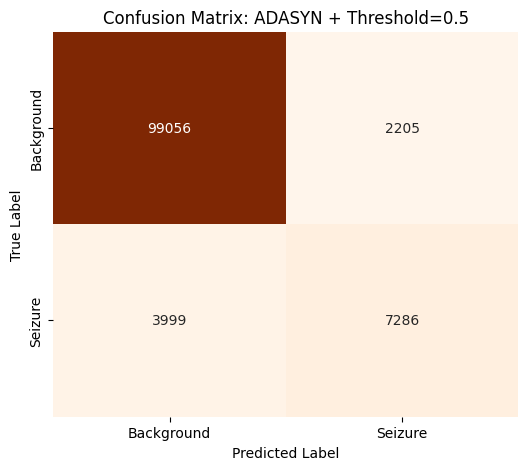

In [3]:
import numpy as np
from pathlib import Path

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models

# ============================================================
# 1) Load full feature set (teacher features) + labels
# ============================================================

BASE_DIR = Path(r"F:\Rice\Rice F25\Seizure Project\Features")
FEATURE_FILE = BASE_DIR / "lightweight_features.npz"

data = np.load(FEATURE_FILE)
X_features = data['X']      # shape (N_windows, N_features)
y_labels   = data['y']      # hard labels (0/1)
print("Features loaded:", X_features.shape, "Labels:", y_labels.shape)

# ------------------------------------------------------------
# Handle Infs / NaNs (same idea as before)
# ------------------------------------------------------------
if np.isinf(X_features).any():
    print("Infinite values detected in feature matrix. Replacing with NaN...")
    X_features[np.isinf(X_features)] = np.nan

if np.isnan(X_features).any():
    print("NaNs detected. Imputing with mean values...")
    imputer = SimpleImputer(strategy='mean')
    X_features = imputer.fit_transform(X_features)
    print("Imputation complete.")
else:
    print("Data is clean (No NaNs/Infs).")

# ============================================================
# 2) Use the *saved scaler* + teacher model to get soft labels
#    (model and scaler are assumed already loaded)
# ============================================================

# Scale full feature matrix exactly like training
X_scaled_for_teacher = scaler.transform(X_features)

# Teacher soft probabilities (continuous [0,1])
teacher_probs = model.predict(X_scaled_for_teacher, batch_size=1024).astype(np.float32).flatten()
print("Teacher probs shape:", teacher_probs.shape)

# ============================================================
# 3) Determine column indices for ECG / EMG / MOV features
#    using the same light extractors & concatenation logic
# ============================================================

# These classes should already exist from your feature extraction step:
# EEGFeatureExtractorLight, ECGFeatureExtractorLight, EMGFeatureExtractorLight,
# MOV1DFeatureExtractorLight, MOVTriaxFeatureExtractorLight

# --- Use dummy inputs to infer feature counts per modality ---
dummy_eeg   = np.random.randn(500)    # 2 seconds @ 250 Hz
dummy_ecg   = np.random.randn(500)
dummy_emg   = np.random.randn(500)
dummy_mov1d = np.random.randn(50)     # 2 seconds @ 25 Hz
dummy_acc   = np.random.randn(50, 3)  # (N,3) accel
dummy_gyro  = np.random.randn(50, 3)  # (N,3) gyro

eeg_ex_l   = EEGFeatureExtractorLight(sfreq=250)
ecg_ex_l   = ECGFeatureExtractorLight(sfreq=250)
emg_ex_l   = EMGFeatureExtractorLight(sfreq=250)
mov1d_ex_l = MOV1DFeatureExtractorLight(sfreq=25)
mov3d_ex_l = MOVTriaxFeatureExtractorLight(sfreq=25, vertical_axis=2)

n_eeg      = len(eeg_ex_l.list_feature_names(dummy_eeg))   # per EEG channel
n_ecg      = len(ecg_ex_l.list_feature_names(dummy_ecg))
n_emg      = len(emg_ex_l.list_feature_names(dummy_emg))
n_mov1d    = len(mov1d_ex_l.list_feature_names(dummy_mov1d))
n_mov_triax= len(mov3d_ex_l.list_feature_names(dummy_acc))

print("Feature counts per block:")
print("  EEG (per channel):", n_eeg)
print("  ECG:", n_ecg)
print("  EMG:", n_emg)
print("  MOV1D (per channel):", n_mov1d)
print("  MOV triax:", n_mov_triax)

# Total expected dimension based on concatenation order used in extraction:
# [EEG ch0, EEG ch1, ECG, EMG, MOV1D ch0..5, MOV_triax]
expected_dim = 2*n_eeg + n_ecg + n_emg + 6*n_mov1d + n_mov_triax
print("Expected total feature dim:", expected_dim)
print("Actual feature dim:", X_features.shape[1])

assert expected_dim == X_features.shape[1], \
    "Feature dimension mismatch – check extractor definitions / order."

# ------------------------------------------------------------
# Compute index ranges
# ------------------------------------------------------------
idx = 0

# EEG (teacher only; not used for student inputs)
eeg_start = idx
eeg_end   = eeg_start + 2*n_eeg    # 2 channels
idx       = eeg_end

# ECG
ecg_start = idx
ecg_end   = ecg_start + n_ecg
idx       = ecg_end

# EMG
emg_start = idx
emg_end   = emg_start + n_emg
idx       = emg_end

# MOV1D (6 channels)
mov1d_start = idx
mov1d_end   = mov1d_start + 6*n_mov1d
idx         = mov1d_end

# MOV triax
movtr_start = idx
movtr_end   = movtr_start + n_mov_triax
idx         = movtr_end

# Sanity
assert movtr_end == X_features.shape[1]

# Student should use ECG + EMG + MOV (1D + triax)
student_cols = np.concatenate([
    np.arange(ecg_start, ecg_end),
    np.arange(emg_start, emg_end),
    np.arange(mov1d_start, mov1d_end),
    np.arange(movtr_start, movtr_end),
])
print("Student feature dim:", len(student_cols))

X_student_full = X_features[:, student_cols]
print("X_student_full shape:", X_student_full.shape)

# ============================================================
# 4) Train/test split for student (use hard labels for stratify)
# ============================================================

X_s_train, X_s_test, y_s_train_soft, y_s_test_soft, y_s_train_hard, y_s_test_hard = train_test_split(
    X_student_full,
    teacher_probs,
    y_labels,
    test_size=0.2,
    random_state=42,
    stratify=y_labels
)

print("Student train shape:", X_s_train.shape, "test:", X_s_test.shape)

# Scale student inputs (new scaler for student)
student_scaler = StandardScaler()
X_s_train_scaled = student_scaler.fit_transform(X_s_train)
X_s_test_scaled  = student_scaler.transform(X_s_test)

# ============================================================
# 5) Define Student DNN with Knowledge Distillation Loss
# ============================================================

input_dim = X_s_train_scaled.shape[1]

def hard_accuracy(y_true_and_teacher, y_pred):
    """
    y_true_and_teacher: (batch, 2)
      [:,0] = hard label (0/1)
      [:,1] = teacher prob (ignored here)
    y_pred: (batch, 1) student prob
    """
    hard = y_true_and_teacher[:, 0]
    hard = tf.cast(hard > 0.5, tf.int32)

    pred = tf.cast(y_pred > 0.5, tf.int32)

    return tf.reduce_mean(tf.cast(tf.equal(hard, pred), tf.float32))


def build_student_model(input_dim):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(256, activation='swish', kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(128, activation='swish', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64, activation='swish', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs, outputs, name="student_dnn")

student = build_student_model(input_dim)
student.summary()

# ------------------------------------------------------------
# Custom KD loss: alpha*BCE(y_true, p_s) + (1-alpha)*KLD(p_teacher, p_s)
# ------------------------------------------------------------
alpha = 0.7

bce = tf.keras.losses.BinaryCrossentropy()
kld = tf.keras.losses.KLDivergence()

# y_true: hard labels (0/1)
# y_soft: teacher probs (passed via sample_weight-like extra input using tf.data)
# We'll pack hard + soft together in a single tensor for loss.

def kd_loss(y_true_and_teacher, y_pred):
    """
    y_true_and_teacher: shape (batch, 2)
        [:,0] = hard label (0/1)
        [:,1] = teacher prob
    y_pred: student prob
    """
    y_true  = y_true_and_teacher[:, 0]
    y_teach = y_true_and_teacher[:, 1]

    # Reshape to (batch,1) for Keras losses
    y_true  = tf.reshape(y_true,  (-1, 1))
    y_teach = tf.reshape(y_teach, (-1, 1))

    loss_bce = bce(y_true, y_pred)
    loss_kld = kld(y_teach, y_pred)

    return alpha * loss_bce + (1.0 - alpha) * loss_kld

student.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss=kd_loss,
    metrics=[hard_accuracy, 'accuracy'],
)

# ============================================================
# 6) Prepare KD targets and train student
# ============================================================

# Stack hard + soft labels into (N,2) tensor
y_train_kd = np.stack([y_s_train_hard.astype(np.float32),
                       y_s_train_soft.astype(np.float32)], axis=1)
y_test_kd  = np.stack([y_s_test_hard.astype(np.float32),
                       y_s_test_soft.astype(np.float32)], axis=1)

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
    ),
]

history_student = student.fit(
    X_s_train_scaled,
    y_train_kd,
    validation_split=0.1,
    epochs=100,
    batch_size=256,
    callbacks=callbacks,
    verbose=1,
)

# ============================================================
# 7) Evaluate student against hard labels (y_s_test_hard)
# ============================================================

y_student_prob = student.predict(X_s_test_scaled, batch_size=1024).flatten()
y_student_pred = (y_student_prob >= 0.5).astype(int)

print("\nStudent Model Performance (threshold=0.5):")
print(classification_report(y_s_test_hard, y_student_pred, target_names=["Background", "Seizure"]))

cm = confusion_matrix(y_s_test_hard, y_student_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=['Background', 'Seizure'],
            yticklabels=['Background', 'Seizure'])
plt.title(f'Confusion Matrix: ADASYN + Threshold=0.5')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


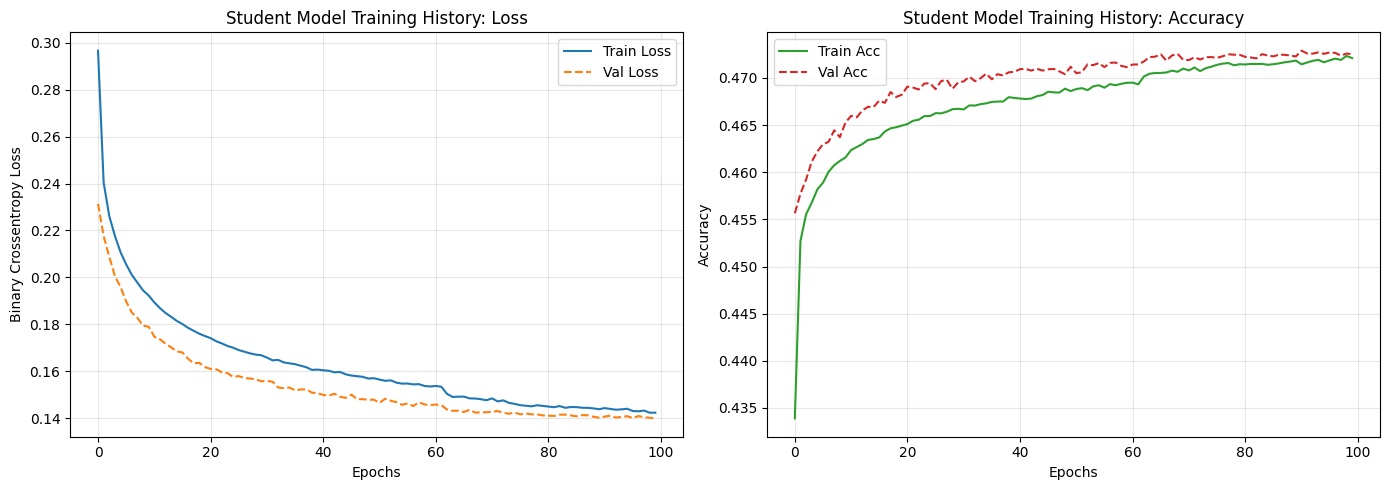

In [4]:
import matplotlib.pyplot as plt

def plot_training_history(history, title="Model Training History"):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Loss
    ax[0].plot(history.history['loss'], label='Train Loss', color='tab:blue')
    ax[0].plot(history.history['val_loss'], label='Val Loss', color='tab:orange', linestyle='--')
    ax[0].set_title(f'{title}: Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Binary Crossentropy Loss')
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    # Plot Accuracy
    ax[1].plot(history.history['accuracy'], label='Train Acc', color='tab:green')
    ax[1].plot(history.history['val_accuracy'], label='Val Acc', color='tab:red', linestyle='--')
    ax[1].set_title(f'{title}: Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_history(history_student, title="Student Model Training History")

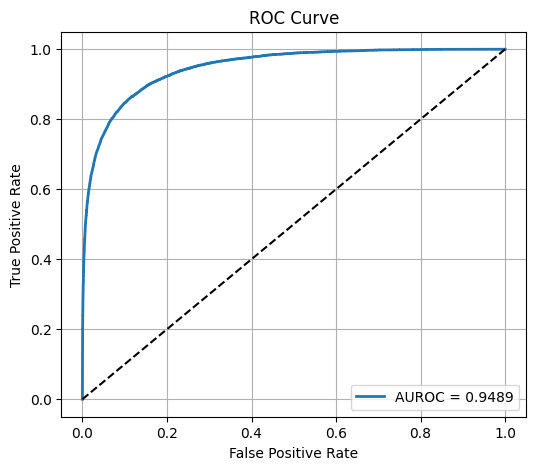

AUROC: 0.9489


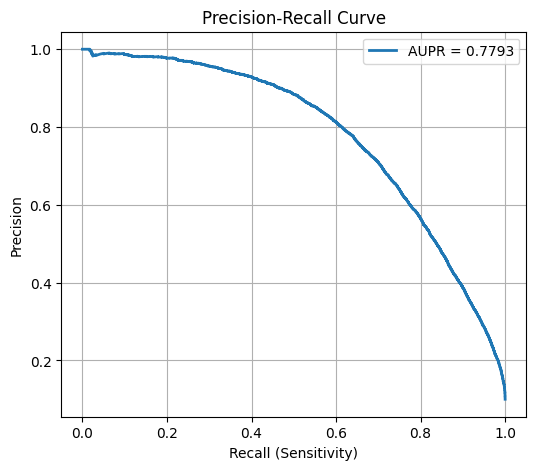

AUPR: 0.7793
Total windows: 112546
Estimated total hours: 519.72
False Alarms: 2205
False Alarms per Hour (FA/hr): 4.2426
Test set hours: 519.724h


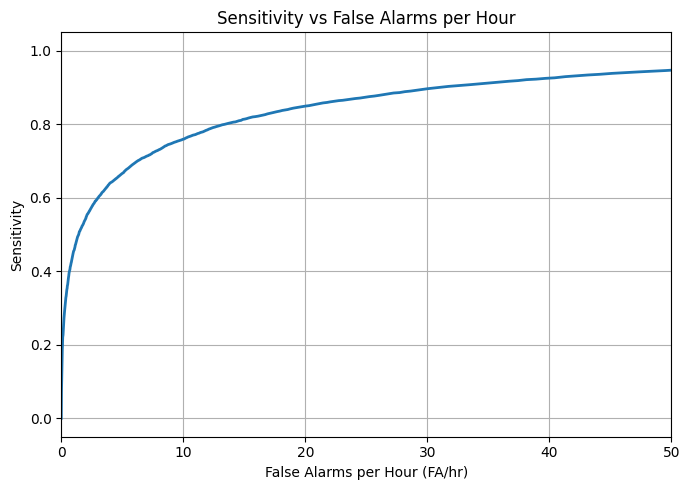

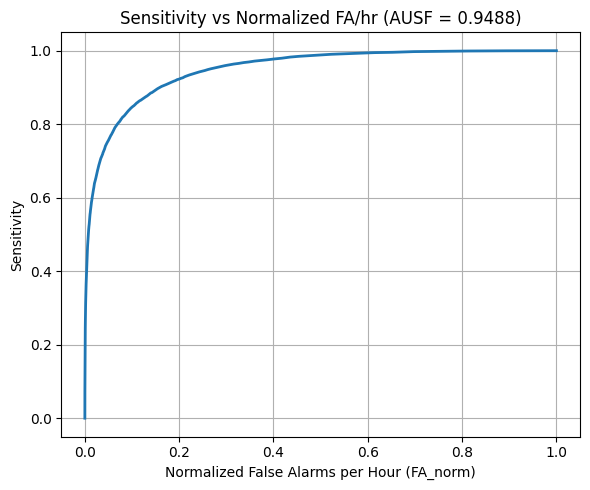

AUSF (SeizeIT2-style): 0.9488


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# ------------------------------------------------------------
# 1. ROC Curve + AUROC
# ------------------------------------------------------------
fpr, tpr, roc_thresholds = roc_curve(y_s_test_hard, y_student_prob)
auroc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUROC = {auroc:.4f}", linewidth=2)
plt.plot([0,1],[0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

print(f"AUROC: {auroc:.4f}")

# ------------------------------------------------------------
# 2. Precision–Recall Curve + AUPR
# ------------------------------------------------------------
precision, recall, pr_thresholds = precision_recall_curve(y_s_test_hard, y_student_prob)
aupr = auc(recall, precision)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"AUPR = {aupr:.4f}", linewidth=2)
plt.xlabel("Recall (Sensitivity)")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.legend()
plt.show()

print(f"AUPR: {aupr:.4f}")

# ------------------------------------------------------------
# 3. False Alarms Per Hour (FA/hr)
# ------------------------------------------------------------

# You must provide total hours of test data.
total_hours = 0.2*2598.62

# Using optimized threshold for FA/hr
best_thresh = 0.5  # CHANGE if you optimized threshold earlier
y_pred_bin = (y_student_pred >= best_thresh)

# False alarms = predicted seizure when ground truth is background
false_alarms = np.sum((y_pred_bin == 1) & (y_s_test_hard == 0))

fa_per_hour = false_alarms / total_hours

print(f"Total windows: {len(y_s_test_hard)}")
print(f"Estimated total hours: {total_hours:.2f}")
print(f"False Alarms: {false_alarms}")
print(f"False Alarms per Hour (FA/hr): {fa_per_hour:.4f}")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# y_test = ground truth (0/1)
# y_pred_prob = model probabilities from your teacher/student model

# --- 1. Define total test hours ---
total_hours = 2598.62 * 0.20  # 20% test split
print(f"Test set hours: {total_hours:.3f}h")

# --- 2. Sweep thresholds ---
thresholds = np.linspace(0, 1, 500)
sens_list = []
fah_list = []

for t in thresholds:
    y_pred = (y_student_prob >= t).astype(int)

    TP = np.sum((y_s_test_hard == 1) & (y_pred == 1))
    FN = np.sum((y_s_test_hard == 1) & (y_pred == 0))
    FP = np.sum((y_s_test_hard == 0) & (y_pred == 1))

    # Sensitivity
    sens = TP / (TP + FN + 1e-9)

    # False alarms per hour
    fa_per_hr = FP / total_hours

    sens_list.append(sens)
    fah_list.append(fa_per_hr)

sens_list = np.array(sens_list)
fah_list = np.array(fah_list)

# --- 3. Plot Sensitivity vs FA/hr ---
plt.figure(figsize=(7, 5))
plt.plot(fah_list, sens_list, linewidth=2)

# Highlight key operating points
# default threshold = 0.5
t_default = 0.5
y_pred_default = (y_student_prob >= t_default).astype(int)
TP = np.sum((y_s_test_hard == 1) & (y_pred_default == 1))
FN = np.sum((y_s_test_hard == 1) & (y_pred_default == 0))
FP = np.sum((y_s_test_hard == 0) & (y_pred_default == 1))
sens_default = TP / (TP + FN + 1e-9)
fa_default = FP / total_hours

plt.xlim(0, 50)   # zoom out of extreme tail
plt.xlabel("False Alarms per Hour (FA/hr)")
plt.ylabel("Sensitivity")
plt.title("Sensitivity vs False Alarms per Hour")
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# 4. AUSF (SeizeIT2-style)
#    Area under Sensitivity vs *normalized* FA/hr curve
# -----------------------------
fa_max = fah_list.max()
if fa_max > 0:
    fa_norm = fah_list / fa_max
else:
    fa_norm = fah_list  # all zeros, degenerate case

ausf = auc(fa_norm, sens_list)

plt.figure(figsize=(6, 5))
plt.plot(fa_norm, sens_list, linewidth=2)
plt.xlabel("Normalized False Alarms per Hour (FA_norm)")
plt.ylabel("Sensitivity")
plt.title(f"Sensitivity vs Normalized FA/hr (AUSF = {ausf:.4f})")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"AUSF (SeizeIT2-style): {ausf:.4f}")


In [6]:
import numpy as np
from pathlib import Path

# Create Results directory if it doesn't exist
results_dir = Path("Results")
results_dir.mkdir(exist_ok=True)
result_file = results_dir / "Lightweight DNN Student 3.npz"

# Save relevant arrays/results
np.savez_compressed(
    result_file,
    y_test=y_s_test_hard,
    y_pred_prob=y_student_prob,
    y_pred_opt=y_student_pred,
    best_thresh=best_thresh,
    sens_arr=sens_list,
    fa_arr=fah_list,
    thresh_grid=thresholds,
    precision=precision,
    recall=recall,
    pr_thresholds=pr_thresholds,
    fpr=fpr,
    tpr=tpr,
    roc_thresholds=roc_thresholds
)

print(f"Saved results to {result_file}")


Saved results to Results\Lightweight DNN Student 3.npz


# TCN Student w/ Hand-Crafted Feature Engineering w/ Knowledge Distillation

In [33]:
import numpy as np
from sklearn.model_selection import train_test_split

# Load original features
BASE_DIR = Path(r"F:\Rice\Rice F25\Seizure Project\Features")
data = np.load(BASE_DIR / "lightweight_features.npz")
X_features = data["X"]
y_labels   = data["y"]

# ------------------------------------------------------------
# Handle Infs / NaNs (same idea as before)
# ------------------------------------------------------------
if np.isinf(X_features).any():
    print("Infinite values detected in feature matrix. Replacing with NaN...")
    X_features[np.isinf(X_features)] = np.nan

if np.isnan(X_features).any():
    print("NaNs detected. Imputing with mean values...")
    imputer = SimpleImputer(strategy='mean')
    X_features = imputer.fit_transform(X_features)
    print("Imputation complete.")
else:
    print("Data is clean (No NaNs/Infs).")

print("X_features:", X_features.shape, " y_labels:", y_labels.shape)

# --- 0.1: select only ECG/EMG/MOV columns for the student ---
# You already did something like this for the previous student DNN.
# Here I'll show a generic pattern. Replace with your actual indices.

# Example: suppose you know the EEG part is first N_eeg features:
N_EEG = 2 *  (X_features.shape[1] // 4)   # <-- just a placeholder!
# Better: plug in the exact index range you used before.
student_idx = np.arange(N_EEG, X_features.shape[1])

X_student = X_features[:, student_idx]
print("Student feature shape:", X_student.shape)

# --- 0.2: train/val split (same as before, stratified) ---
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X_features, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)

X_train_student = X_student[y_train.index if hasattr(y_train, "index") else None] \
    if isinstance(y_train, np.ndarray) else None  # only needed if using pandas
# easier: recompute directly from indices

train_idx = np.arange(len(y_labels))[ : len(y_labels) - len(y_test) ]
test_idx  = np.arange(len(y_labels))[ len(y_labels) - len(y_test) : ]

X_train_student = X_student[train_idx]
X_test_student  = X_student[test_idx]

print("Train student:", X_train_student.shape, " Test student:", X_test_student.shape)

# --- 0.3: scale using the same scaler you already fit on X_train_full ---
X_train_full_scaled = scaler.transform(X_train_full)
X_test_full_scaled  = scaler.transform(X_test_full)

# --- 0.4: teacher soft labels on train/test splits ---
teacher_train_probs = model.predict(X_train_full_scaled, batch_size=1024).ravel()
teacher_test_probs  = model.predict(X_test_full_scaled,  batch_size=1024).ravel()

print("Teacher soft labels:", teacher_train_probs.shape, teacher_test_probs.shape)


Infinite values detected in feature matrix. Replacing with NaN...
NaNs detected. Imputing with mean values...
Imputation complete.
X_features: (562729, 274)  y_labels: (562729,)
Student feature shape: (562729, 138)
Train student: (450183, 138)  Test student: (112546, 138)
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Teacher soft labels: (450183,) (112546,)


In [34]:
import tensorflow as tf

n_student_features = X_train_student.shape[1]

X_train_tcn = X_train_student.reshape(-1, n_student_features, 1)
X_test_tcn  = X_test_student.reshape(-1, n_student_features, 1)

print("TCN input shapes:")
print("  Train:", X_train_tcn.shape)
print("  Test :", X_test_tcn.shape)


TCN input shapes:
  Train: (450183, 138, 1)
  Test : (112546, 138, 1)


In [35]:
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Dropout,
    Add, GlobalAveragePooling1D, Dense
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_tcn_student(input_length, n_filters=64, kernel_size=3, n_blocks=4, dropout_rate=0.2):
    inp = Input(shape=(input_length, 1), name="student_features_seq")
    x = inp

    dilation_rates = [2**i for i in range(n_blocks)]  # [1, 2, 4, 8]

    for d in dilation_rates:
        residual = x

        x = Conv1D(
            filters=n_filters,
            kernel_size=kernel_size,
            padding="causal",
            dilation_rate=d,
            activation="swish",
            kernel_initializer="he_normal"
        )(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)

        # match residual channels if needed
        if residual.shape[-1] != x.shape[-1]:
            residual = Conv1D(
                filters=n_filters,
                kernel_size=1,
                padding="same",
                activation=None
            )(residual)

        x = Add()([x, residual])

    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation="swish", kernel_initializer="he_normal")(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation="swish", kernel_initializer="he_normal")(x)
    x = Dropout(0.2)(x)

    out = Dense(1, activation="sigmoid", name="student_output")(x)

    model_tcn = Model(inputs=inp, outputs=out, name="TCN_Student")
    return model_tcn

student_tcn = build_tcn_student(n_student_features)
student_tcn.summary()

student_tcn.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="binary_crossentropy",       # BCE with teacher probabilities in [0,1]
    metrics=[tf.keras.metrics.AUC(name="auc")]
)


Model: "TCN_Student"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ student_features_s… │ (None, 138, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 138, 64)   │        256 │ student_features… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 138, 64)   │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 138, 64)   │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 138, 64)   │        128 │ student_features… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 138, 64)   │          0 │ dropout_12[0][0], │
│                     │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 138, 64)   │     12,352 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 138, 64)   │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 138, 64)   │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 138, 64)   │          0 │ dropout_13[0][0], │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 138, 64)   │     12,352 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 138, 64)   │        256 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 138, 64)   │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 138, 64)   │          0 │ dropout_14[0][0], │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 138, 64)   │     12,352 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 138, 64)   │        256 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 138, 64)   │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 138, 64)   │          0 │ dropout_15[0][0], │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 55,105 (215.25 KB)

 Trainable params: 54,593 (213.25 KB)

 Non-trainable params: 512 (2.00 KB)

In [36]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5,
        min_lr=1e-6, verbose=1
    ),
    EarlyStopping(
        monitor="val_loss", patience=15,
        restore_best_weights=True, verbose=1
    )
]

history_tcn = student_tcn.fit(
    X_train_tcn, teacher_train_probs,
    validation_data=(X_test_tcn, teacher_test_probs),
    epochs=100,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/100
3518/3518 ━━━━━━━━━━━━━━━━━━━━ 96s 27ms/step - auc: 0.5362 - loss: 1.5875 - val_auc: 0.4621 - val_loss: 0.4220 - learning_rate: 0.0010
Epoch 2/100
3518/3518 ━━━━━━━━━━━━━━━━━━━━ 93s 26ms/step - auc: 0.5175 - loss: 0.4195 - val_auc: 0.4898 - val_loss: 0.4218 - learning_rate: 0.0010
Epoch 3/100
3518/3518 ━━━━━━━━━━━━━━━━━━━━ 100s 28ms/step - auc: 0.4869 - loss: 0.4181 - val_auc: 0.5000 - val_loss: 0.4218 - learning_rate: 0.0010
Epoch 4/100
3518/3518 ━━━━━━━━━━━━━━━━━━━━ 99s 28ms/step - auc: 0.5140 - loss: 0.4162 - val_auc: 0.5000 - val_loss: 0.4218 - learning_rate: 0.0010
Epoch 5/100
3518/3518 ━━━━━━━━━━━━━━━━━━━━ 100s 28ms/step - auc: 0.4964 - loss: 0.4166 - val_auc: 0.5000 - val_loss: 0.4219 - learning_rate: 0.0010
Epoch 6/100
3518/3518 ━━━━━━━━━━━━━━━━━━━━ 100s 28ms/step - auc: 0.5296 - loss: 0.4170 - val_auc: 0.5000 - val_loss: 0.4218 - learning_rate: 0.0010
Epoch 7/100
3516/3518 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - auc: 0.4965 - loss: 0.4190
Epoch 7: ReduceLROnPlateau red

In [38]:
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_curve, roc_curve, auc
)

# Student probabilities on test set
student_probs = student_tcn.predict(X_test_tcn, batch_size=1024).ravel()

# Default threshold 0.5 (you can re-optimize threshold like before)
y_pred_05 = (student_probs >= 0.5).astype(int)

print("Student TCN vs TRUE labels (threshold=0.5):")
print(classification_report(y_test, y_pred_05, target_names=["Background", "Seizure"]))

cm = confusion_matrix(y_test, y_pred_05)
print("Confusion matrix:\n", cm)

# ROC / PR metrics
fpr, tpr, _ = roc_curve(y_test, student_probs)
prec, rec, _ = precision_recall_curve(y_test, student_probs)
auroc = auc(fpr, tpr)
aupr  = auc(rec, prec)

print(f"TCN Student AUROC = {auroc:.4f}")
print(f"TCN Student AUPR  = {aupr:.4f}")


110/110 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step
Student TCN vs TRUE labels (threshold=0.5):
              precision    recall  f1-score   support

  Background       0.90      1.00      0.95    101261
     Seizure       0.00      0.00      0.00     11285

    accuracy                           0.90    112546
   macro avg       0.45      0.50      0.47    112546
weighted avg       0.81      0.90      0.85    112546

Confusion matrix:
 [[101261      0]
 [ 11285      0]]
TCN Student AUROC = 0.5042
TCN Student AUPR  = 0.4123


c:\ProgramData\miniconda3\envs\torchenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\torchenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\miniconda3\envs\torchenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

# TCN Student w/ Raw Signal (No Hand-Crafted Features) w/ Knowledge Distillation

In [3]:
from pathlib import Path
import numpy as np
import tensorflow as tf
import pickle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

BASE_DIR = Path(r"F:\Rice\Rice F25\Seizure Project\Features")
data = np.load(BASE_DIR / "lightweight_features.npz")
X_features = data["X"]          # (N, n_features)
y_labels   = data["y"]          # (N,)
print(X_features.shape, y_labels.shape)

# ------------------------------------------------------------
# Handle Infs / NaNs (same idea as before)
# ------------------------------------------------------------
if np.isinf(X_features).any():
    print("Infinite values detected in feature matrix. Replacing with NaN...")
    X_features[np.isinf(X_features)] = np.nan

if np.isnan(X_features).any():
    print("NaNs detected. Imputing with mean values...")
    imputer = SimpleImputer(strategy='mean')
    X_features = imputer.fit_transform(X_features)
    print("Imputation complete.")
else:
    print("Data is clean (No NaNs/Infs).")

# Scale with the existing scaler you fit earlier
X_scaled_all = scaler.transform(X_features)

# Teacher soft labels for *every* window
teacher_probs_all = model.predict(X_scaled_all, batch_size=1024).ravel()
print("teacher_probs_all:", teacher_probs_all.shape)


(562729, 274) (562729,)
Infinite values detected in feature matrix. Replacing with NaN...
NaNs detected. Imputing with mean values...
Imputation complete.
550/550 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
teacher_probs_all: (562729,)


In [4]:
import pickle
from pathlib import Path
import numpy as np

DATA_DIR   = Path(r"F:\Rice\Rice F25\Seizure Project\Processed_Gemini_V5_Augmented")
MANIFEST   = BASE_DIR / "processing_manifest.pkl"

with open(MANIFEST, "rb") as f:
    manifest = pickle.load(f)   # {filename: [idx0, idx1, ...]}

X_bio_all = []
X_mov_all = []
y_all     = []

for fname, idxs in manifest.items():
    npz_path = DATA_DIR / fname
    with np.load(npz_path) as d:
        X_bio = d["X_student_bio"]   # (n_win, 2, 500)
        X_mov = d["X_student_mov"]   # (n_win, 6, 50)
        y     = d["y"]               # (n_win,)

        # subset in the same order used during feature extraction
        X_bio_sel = X_bio[idxs]      # (k, 2, 500)
        X_mov_sel = X_mov[idxs]      # (k, 6, 50)
        y_sel     = y[idxs]

        # transpose to (time, channels)
        X_bio_all.append(np.transpose(X_bio_sel, (0, 2, 1)))  # -> (k, 500, 2)
        X_mov_all.append(np.transpose(X_mov_sel, (0, 2, 1)))  # -> (k, 50, 6)
        y_all.append(y_sel)

X_bio_all = np.concatenate(X_bio_all, axis=0)
X_mov_all = np.concatenate(X_mov_all, axis=0)
y_all     = np.concatenate(y_all, axis=0)

print("Raw shapes before alignment:",
      X_bio_all.shape, X_mov_all.shape, y_all.shape,
      X_features.shape, teacher_probs_all.shape, y_labels.shape)

# ---------- ALIGN TO TEACHER / FEATURES ----------
N = teacher_probs_all.shape[0]   # 562,729

X_bio_all = X_bio_all[:N].astype("float16")
X_mov_all = X_mov_all[:N].astype("float16")
y_all     = y_all[:N].astype("int8")

teacher_probs_all = teacher_probs_all.astype("float32")

print("After alignment:")
print("  X_bio_all:", X_bio_all.shape)
print("  X_mov_all:", X_mov_all.shape)
print("  y_all:    ", y_all.shape)
print("  teacher_probs_all:", teacher_probs_all.shape)

# ---------- OPTIONAL: SUBSAMPLE FOR RAM (e.g., 100k windows) ----------
max_N = 100_000  # tweak as needed
if N > max_N:
    rng = np.random.default_rng(42)
    sub_idx = rng.choice(N, size=max_N, replace=False)

    X_bio_all          = X_bio_all[sub_idx]
    X_mov_all          = X_mov_all[sub_idx]
    y_all              = y_all[sub_idx]
    teacher_probs_all  = teacher_probs_all[sub_idx]
    N = max_N

    print(f"\nSubsampled to {N} windows for student training.")

print("Final shapes for student dataset:")
print("  X_bio_all:", X_bio_all.shape)
print("  X_mov_all:", X_mov_all.shape)
print("  y_all:    ", y_all.shape)
print("  teacher_probs_all:", teacher_probs_all.shape)


Raw shapes before alignment: (562817, 500, 2) (562817, 50, 6) (562817,) (562729, 274) (562729,) (562729,)
After alignment:
  X_bio_all: (562729, 500, 2)
  X_mov_all: (562729, 50, 6)
  y_all:     (562729,)
  teacher_probs_all: (562729,)

Subsampled to 100000 windows for student training.
Final shapes for student dataset:
  X_bio_all: (100000, 500, 2)
  X_mov_all: (100000, 50, 6)
  y_all:     (100000,)
  teacher_probs_all: (100000,)


In [5]:
from sklearn.model_selection import train_test_split

# Use aligned arrays
N = X_bio_all.shape[0]
idx = np.arange(N)

# Hard labels for stratification / later eval
idx_train, idx_test, y_train_hard, y_test_hard = train_test_split(
    idx,
    y_all,
    test_size=0.2,
    random_state=42,
    stratify=y_all
)

X_bio_train = X_bio_all[idx_train]
X_bio_test  = X_bio_all[idx_test]
X_mov_train = X_mov_all[idx_train]
X_mov_test  = X_mov_all[idx_test]

# Teacher soft labels for distillation
teacher_train = teacher_probs_all[idx_train]
teacher_test  = teacher_probs_all[idx_test]

print("Train BIO:", X_bio_train.shape, "  Train MOV:", X_mov_train.shape)
print("Test  BIO:", X_bio_test.shape,  "  Test  MOV:", X_mov_test.shape)
print("Teacher labels train/test:", teacher_train.shape, teacher_test.shape)
print("Hard labels train/test:", y_train_hard.shape, y_test_hard.shape)


Train BIO: (80000, 500, 2)   Train MOV: (80000, 50, 6)
Test  BIO: (20000, 500, 2)   Test  MOV: (20000, 50, 6)
Teacher labels train/test: (80000,) (20000,)
Hard labels train/test: (80000,) (20000,)


In [6]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Dropout,
    Add, GlobalAveragePooling1D, Concatenate, Dense
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def tcn_block(x, n_filters, kernel_size, dilation_rate, dropout_rate=0.2):
    residual = x

    x = Conv1D(
        filters=n_filters,
        kernel_size=kernel_size,
        padding="causal",
        dilation_rate=dilation_rate,
        activation="swish",
        kernel_initializer="he_normal"
    )(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    # Match residual channels if needed
    if int(residual.shape[-1]) != n_filters:
        residual = Conv1D(
            filters=n_filters,
            kernel_size=1,
            padding="same",
            activation=None
        )(residual)

    x = Add()([x, residual])
    return x

def build_raw_tcn_student(
    bio_len=500, bio_ch=2,
    mov_len=50,  mov_ch=6,
    n_filters_bio=32,
    n_filters_mov=16,
    kernel_size=3,
    n_blocks=3
):
    # --- ECG/EMG branch (250 Hz) ---
    inp_bio = Input(shape=(bio_len, bio_ch), name="bio_input")
    x_bio = inp_bio
    for d in [1, 2, 4][:n_blocks]:
        x_bio = tcn_block(x_bio, n_filters_bio, kernel_size, dilation_rate=d, dropout_rate=0.2)
    x_bio = GlobalAveragePooling1D()(x_bio)

    # --- MOV branch (25 Hz) ---
    inp_mov = Input(shape=(mov_len, mov_ch), name="mov_input")
    x_mov = inp_mov
    for d in [1, 2]:
        x_mov = tcn_block(x_mov, n_filters_mov, kernel_size=3, dilation_rate=d, dropout_rate=0.2)
    x_mov = GlobalAveragePooling1D()(x_mov)

    # --- Fusion ---
    x = Concatenate()([x_bio, x_mov])
    x = Dense(64, activation="swish", kernel_initializer="he_normal")(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation="swish", kernel_initializer="he_normal")(x)
    x = Dropout(0.2)(x)

    out = Dense(1, activation="sigmoid", name="student_output")(x)

    model = Model(inputs=[inp_bio, inp_mov], outputs=out, name="Raw_TCN_Student_Light")
    return model

student_tcn = build_raw_tcn_student()
student_tcn.summary()

student_tcn.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="binary_crossentropy",   # distillation to teacher_probs
    metrics=[tf.keras.metrics.AUC(name="auc"), "accuracy"]
)


Model: "Raw_TCN_Student_Light"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ bio_input           │ (None, 500, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 500, 32)   │        224 │ bio_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 500, 32)   │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 500, 32)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 500, 32)   │         96 │ bio_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 500, 32)   │          0 │ dropout[0][0],    │
│                     │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mov_input           │ (None, 50, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 500, 32)   │      3,104 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 50, 16)    │        304 │ mov_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 500, 32)   │        128 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 16)    │         64 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 500, 32)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 50, 16)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 50, 16)    │        112 │ mov_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 500, 32)   │          0 │ dropout_1[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 50, 16)    │          0 │ dropout_3[0][0],  │
│                     │                   │            │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 500, 32)   │      3,104 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 50, 16)    │        784 │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 500, 32)   │        128 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 16)    │         64 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 13,489 (52.69 KB)

 Trainable params: 13,233 (51.69 KB)

 Non-trainable params: 256 (1.00 KB)

In [7]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
callbacks = [ ReduceLROnPlateau( 
                                monitor="val_loss", 
                                factor=0.5, 
                                patience=5, 
                                min_lr=1e-6,
                                verbose=1 ), 
             EarlyStopping( monitor="val_loss", 
                           patience=15, 
                           restore_best_weights=True, 
                           verbose=1 ) ]

history_tcn = student_tcn.fit(
    [X_bio_train, X_mov_train],
    teacher_train,
    validation_data=([X_bio_test, X_mov_test], teacher_test),
    epochs=100,
    batch_size=32,   # instead of 128
    callbacks=callbacks,
    verbose=1
)


Epoch 1/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - accuracy: 8.8127e-04 - auc: 0.3557 - loss: 0.4213 - val_accuracy: 5.0000e-04 - val_auc: 0.2256 - val_loss: 0.3834 - learning_rate: 0.0010
Epoch 2/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 8.1274e-04 - auc: 0.3439 - loss: 0.3713 - val_accuracy: 5.0000e-04 - val_auc: 0.3233 - val_loss: 0.3620 - learning_rate: 0.0010
Epoch 3/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 9.2238e-04 - auc: 0.3514 - loss: 0.3539 - val_accuracy: 5.5000e-04 - val_auc: 0.4579 - val_loss: 0.3495 - learning_rate: 0.0010
Epoch 4/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 6.5528e-04 - auc: 0.2924 - loss: 0.3478 - val_accuracy: 5.5000e-04 - val_auc: 0.4400 - val_loss: 0.3426 - learning_rate: 0.0010
Epoch 5/100
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 9.4331e-04 - auc: 0.3376 - loss: 0.3444 - val_accuracy: 5.5000e-04 - val_auc: 0.3379 - val_loss: 0.3429 - learning_rate: 0.0010
Epoch 6/100
250

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step
Raw TCN Student vs TRUE labels (threshold=0.5):
              precision    recall  f1-score   support

  Background       0.94      0.98      0.96     17976
     Seizure       0.76      0.47      0.58      2024

    accuracy                           0.93     20000
   macro avg       0.85      0.72      0.77     20000
weighted avg       0.92      0.93      0.92     20000

Confusion matrix:
 [[17671   305]
 [ 1079   945]]
Raw TCN Student AUROC = 0.8870
Raw TCN Student AUPR  = 0.6450


Text(0.5, 1.0, 'Confusion Matrix: Raw TCN Student (Threshold=0.5)')

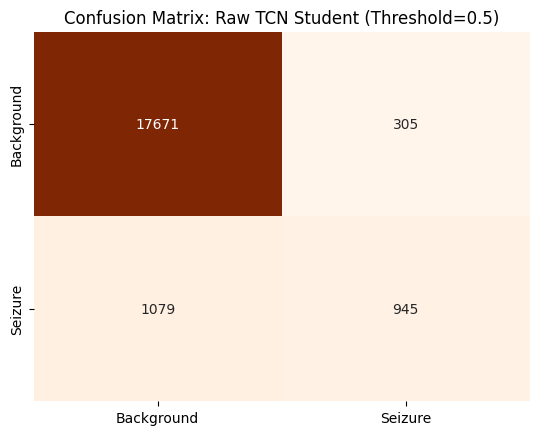

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_curve, roc_curve, auc
)

# Probabilities on test set
student_probs = student_tcn.predict([X_bio_test, X_mov_test], batch_size=1024).ravel()

# Default hard threshold 0.5 (you can re-optimize later)
y_pred_05 = (student_probs >= 0.5).astype(int)

print("Raw TCN Student vs TRUE labels (threshold=0.5):")
print(classification_report(y_test_hard, y_pred_05, target_names=["Background", "Seizure"]))

cm = confusion_matrix(y_test_hard, y_pred_05)
print("Confusion matrix:\n", cm)

# ROC / PR
fpr, tpr, _ = roc_curve(y_test_hard, student_probs)
prec, rec, _ = precision_recall_curve(y_test_hard, student_probs)
auroc = auc(fpr, tpr)
aupr  = auc(rec, prec)

print(f"Raw TCN Student AUROC = {auroc:.4f}")
print(f"Raw TCN Student AUPR  = {aupr:.4f}")

sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=['Background', 'Seizure'],
            yticklabels=['Background', 'Seizure'])
plt.title(f'Confusion Matrix: Raw TCN Student (Threshold=0.5)')


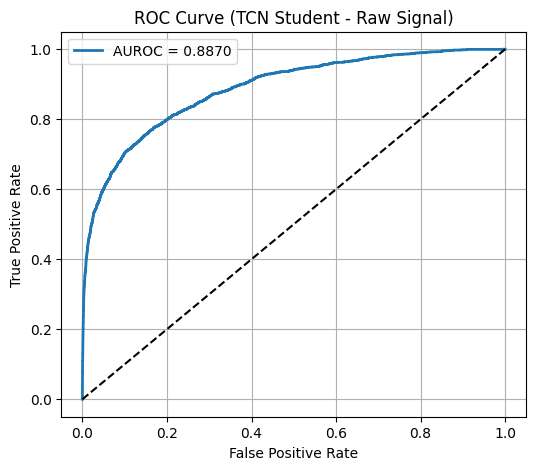

AUROC: 0.8870


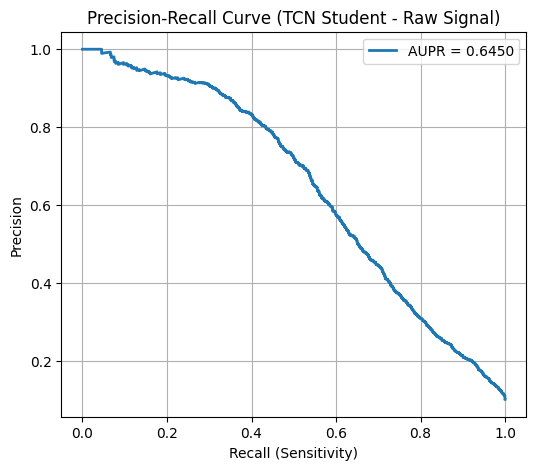

AUPR: 0.6450
Total windows: 20000
Estimated total hours: 5.54
False Alarms: 305
False Alarms per Hour (FA/hr): 55.0656


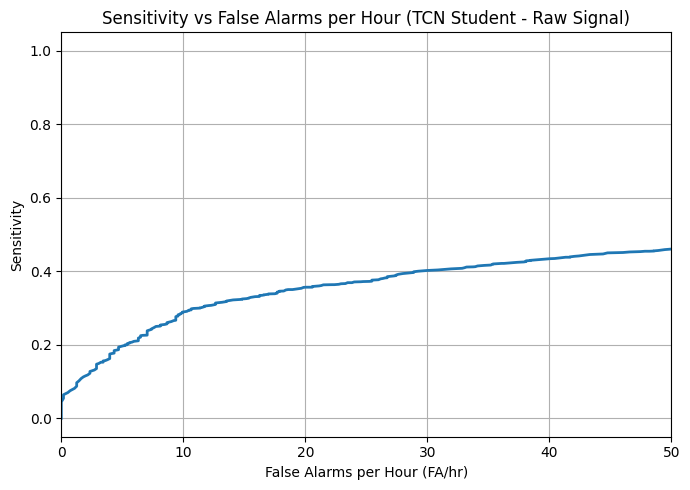

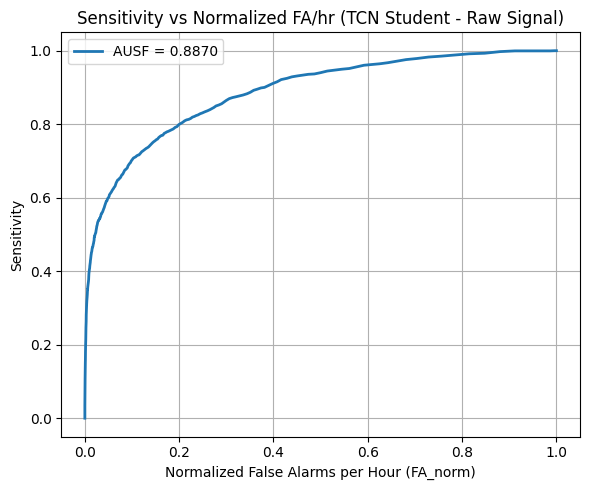

AUSF (SeizeIT2-style): 0.8870


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# ------------------------------------------------------------
# 1. ROC Curve + AUROC
# ------------------------------------------------------------
fpr, tpr, roc_thresholds = roc_curve(y_test_hard, student_probs)
auroc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUROC = {auroc:.4f}", linewidth=2)
plt.plot([0,1],[0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (TCN Student - Raw Signal)")
plt.legend()
plt.grid(True)
plt.show()

print(f"AUROC: {auroc:.4f}")

# ------------------------------------------------------------
# 2. Precision–Recall Curve + AUPR
# ------------------------------------------------------------
precision, recall, pr_thresholds = precision_recall_curve(y_test_hard, student_probs)
aupr = auc(recall, precision)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"AUPR = {aupr:.4f}", linewidth=2)
plt.xlabel("Recall (Sensitivity)")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (TCN Student - Raw Signal)")
plt.grid(True)
plt.legend()
plt.show()

print(f"AUPR: {aupr:.4f}")

# ------------------------------------------------------------
# 3. False Alarms Per Hour (FA/hr)
# ------------------------------------------------------------

# You must provide total hours of test data.
TOTAL_WINDOWS = 9_383_242      # from preprocessing summary
COVERAGE_HOURS = 2598.62       # "Approximate Recording Coverage (dynamic strides)"

hours_per_window = COVERAGE_HOURS / TOTAL_WINDOWS

# For whatever test set you're evaluating on:
n_test = len(y_test_hard)  # y_test for teacher or student

total_hours = n_test * hours_per_window

# Using optimized threshold for FA/hr
best_thresh = 0.5  # CHANGE if you optimized threshold earlier
y_pred_bin = (student_probs >= best_thresh)

# False alarms = predicted seizure when ground truth is background
false_alarms = np.sum((y_pred_bin == 1) & (y_test_hard == 0))

fa_per_hour = false_alarms / total_hours

print(f"Total windows: {len(y_test_hard)}")
print(f"Estimated total hours: {total_hours:.2f}")
print(f"False Alarms: {false_alarms}")
print(f"False Alarms per Hour (FA/hr): {fa_per_hour:.4f}")

# --- 2. Sweep thresholds ---
thresholds = np.linspace(0, 1, 500)
sens_list = []
fah_list = []

for t in thresholds:
    y_pred = (student_probs >= t).astype(int)

    TP = np.sum((y_test_hard == 1) & (y_pred == 1))
    FN = np.sum((y_test_hard == 1) & (y_pred == 0))
    FP = np.sum((y_test_hard == 0) & (y_pred == 1))

    # Sensitivity
    sens = TP / (TP + FN + 1e-9)

    # False alarms per hour
    fa_per_hr = FP / total_hours

    sens_list.append(sens)
    fah_list.append(fa_per_hr)

sens_list = np.array(sens_list)
fah_list = np.array(fah_list)

# --- 3. Plot Sensitivity vs FA/hr ---
plt.figure(figsize=(7, 5))
plt.plot(fah_list, sens_list, linewidth=2)

# Highlight key operating points
# default threshold = 0.5
t_default = 0.5
y_pred_default = (student_probs >= t_default).astype(int)
TP = np.sum((y_test_hard == 1) & (y_pred_default == 1))
FN = np.sum((y_test_hard == 1) & (y_pred_default == 0))
FP = np.sum((y_test_hard == 0) & (y_pred_default == 1))
sens_default = TP / (TP + FN + 1e-9)
fa_default = FP / total_hours

plt.xlim(0, 50)   # zoom out of extreme tail
plt.xlabel("False Alarms per Hour (FA/hr)")
plt.ylabel("Sensitivity")
plt.title("Sensitivity vs False Alarms per Hour (TCN Student - Raw Signal)")
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# 4. AUSF (SeizeIT2-style)
#    Area under Sensitivity vs *normalized* FA/hr curve
# -----------------------------
fa_max = fah_list.max()
if fa_max > 0:
    fa_norm = fah_list / fa_max
else:
    fa_norm = fah_list  # all zeros, degenerate case

ausf = auc(fa_norm, sens_list)

plt.figure(figsize=(6, 5))
plt.plot(fa_norm, sens_list, label=f"AUSF = {ausf:.4f}", linewidth=2)
plt.xlabel("Normalized False Alarms per Hour (FA_norm)")
plt.ylabel("Sensitivity")
plt.title(f"Sensitivity vs Normalized FA/hr (TCN Student - Raw Signal)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"AUSF (SeizeIT2-style): {ausf:.4f}")


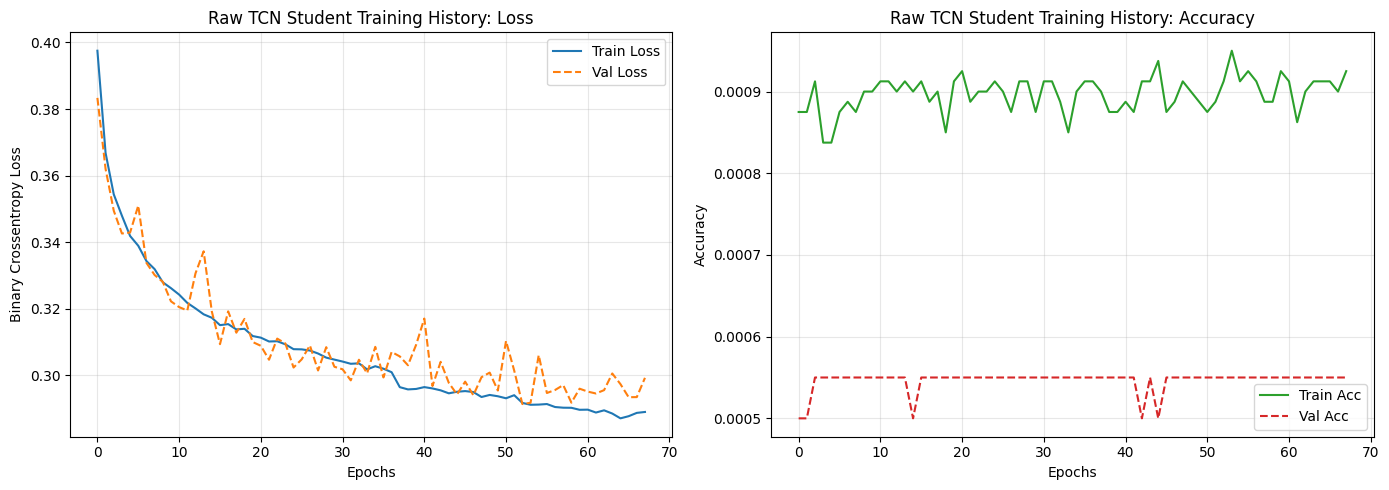

In [10]:
import matplotlib.pyplot as plt

def plot_training_history(history, title="Model Training History"):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Loss
    ax[0].plot(history.history['loss'], label='Train Loss', color='tab:blue')
    ax[0].plot(history.history['val_loss'], label='Val Loss', color='tab:orange', linestyle='--')
    ax[0].set_title(f'{title}: Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Binary Crossentropy Loss')
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    # Plot Accuracy
    ax[1].plot(history.history['accuracy'], label='Train Acc', color='tab:green')
    ax[1].plot(history.history['val_accuracy'], label='Val Acc', color='tab:red', linestyle='--')
    ax[1].set_title(f'{title}: Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_history(history_tcn, title="Raw TCN Student Training History")

In [11]:
import numpy as np
from pathlib import Path

# Create Results directory if it doesn't exist
results_dir = Path("Results")
results_dir.mkdir(exist_ok=True)
result_file = results_dir / "Lightweight Nerfed TCN Student 3.npz"

# Save relevant arrays/results for the TCN student with raw signal
np.savez_compressed(
    result_file,
    y_test=y_test_hard,
    y_pred_prob=student_probs,
    y_pred_opt=y_pred_05,
    best_thresh=best_thresh,
    sens_arr=sens_list,
    fa_arr=fah_list,
    thresh_grid=thresholds,
    precision=precision,
    recall=recall,
    pr_thresholds=pr_thresholds,
    fpr=fpr,
    tpr=tpr,
    roc_thresholds=roc_thresholds
)

print(f"Saved results to {result_file}")

Saved results to Results\Lightweight Nerfed TCN Student 3.npz
